# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


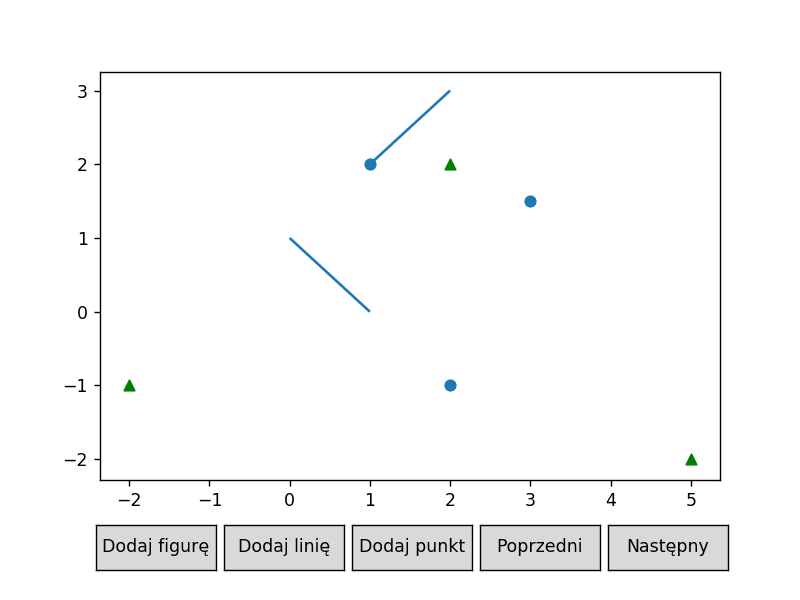

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


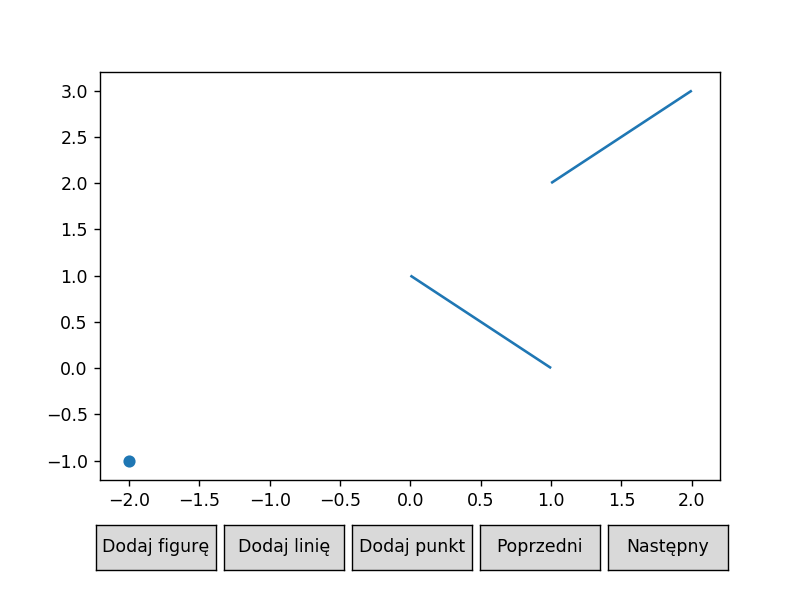

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


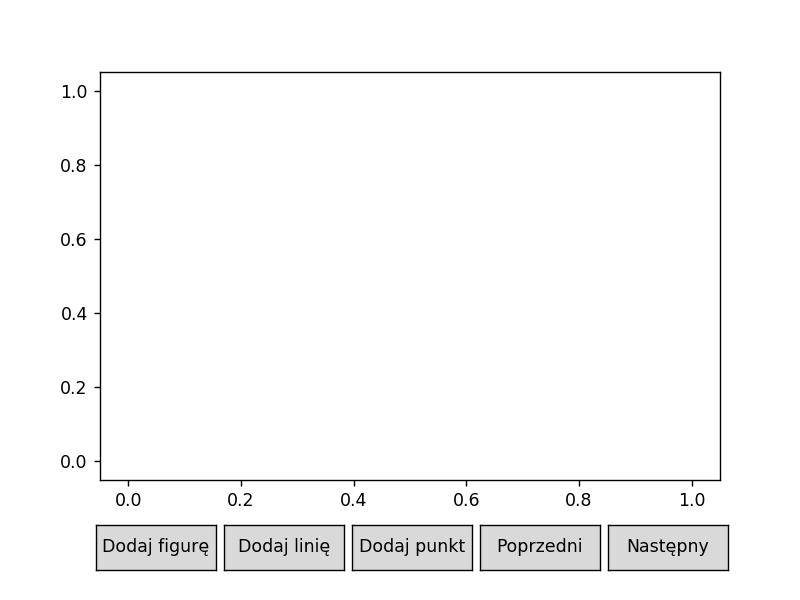

In [5]:
#Dodaj tu punkty, figury i/lub odcinki!
#scenes=[Scene([PointsCollection([])])]
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


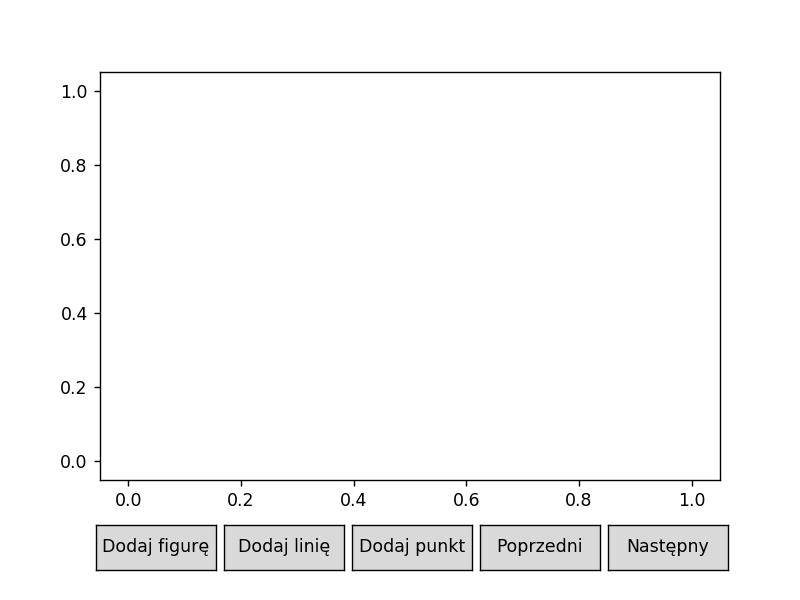

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

<IPython.core.display.Javascript object>


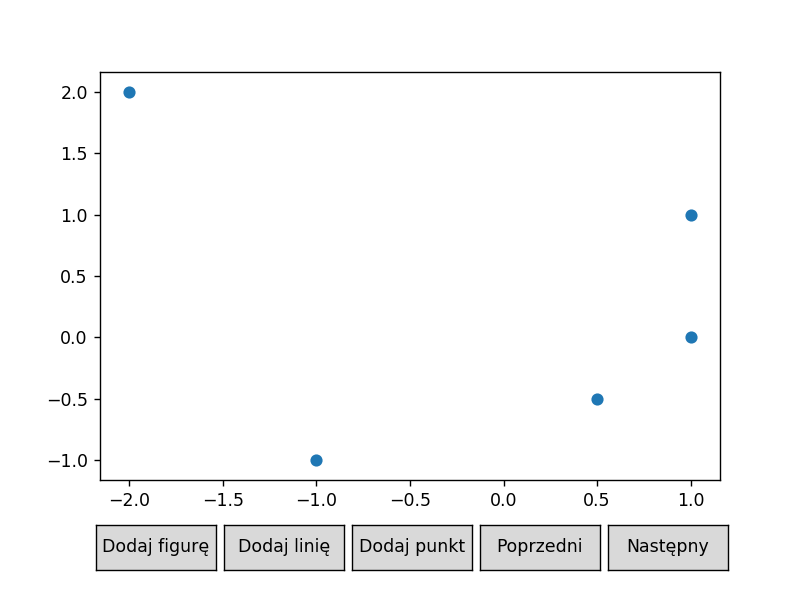

In [7]:
%matplotlib notebook

polygon=[(1,1),(1,0),(0.5,-0.5),(-1,-1),(-2,2)]
scenes=[Scene([PointsCollection(polygon)])]
plot2 = Plot(scenes)
plot2.draw()


<IPython.core.display.Javascript object>


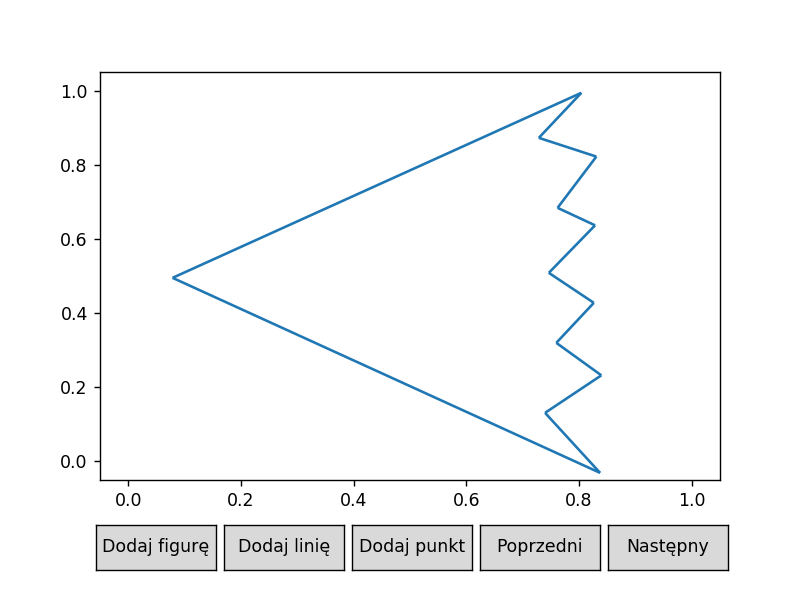

In [8]:
%matplotlib notebook
scenes=[Scene([PointsCollection([])])]
plot1 = Plot(scenes)
plot1.draw()

<IPython.core.display.Javascript object>


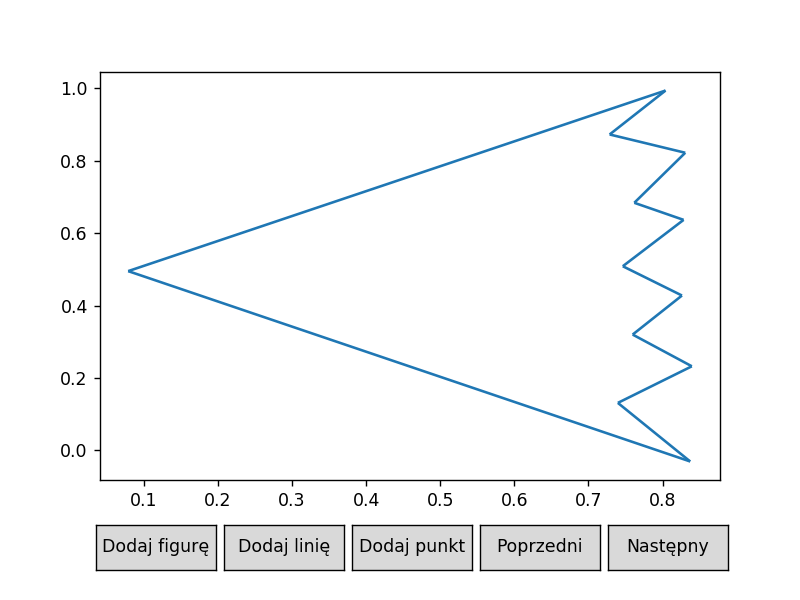

In [9]:
%matplotlib notebook
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()


In [10]:
%matplotlib notebook
addedElements=plot1.get_added_figure()
lines=addedElements[0].lines
#for x in lines :
#    print(x)

In [11]:
def changeOrder(lines):
    minY=lines[0][0][1]
    minYL=lines[0]
    linesInOrder=[]
    for l in lines:
        if minY>l[0][1]:
            minY=min(minY,l[0][1])
            minYL=l
    for x in range (lines.index(minYL),len(lines)):
        linesInOrder.append(lines[x])
    for x in range (0,lines.index(minYL)):
        linesInOrder.append(lines[x])
    return linesInOrder


In [12]:
#print(changeOrder(lines))

In [13]:
def divideToSides(lines):
    leftSide=[]
    rightSide=[]
    x=0
    while(x<len(lines)):
        firstY=lines[x][0][1]
        secondY=lines[x][1][1]
        if(firstY<secondY):
            rightSide.append(lines[x])
        else:
            leftSide.append(lines[x])
        x+=1
    
    return leftSide,rightSide

In [14]:
def checkIfSamePoint(p1,p2):
    return (p1[0]==p2[0] and p1[1]==p2[1])

In [15]:
def checkOneSide(lines):
    for i in range(0,len(lines)-1):
        if not(checkIfSamePoint( lines[i][1],lines[(i+1)][0] )):
           return False 
    return True

In [16]:
def sortFigure(lines):
    sortedLines=[]
    sortedLines.append(lines[0])
    for l in range(0,len(lines)-1):
        for j in range(0,len(lines)):
            if(checkIfSamePoint(lines[l][1],lines[j][0])):
                sortedLines.append(lines[j])
    return sortedLines


In [17]:
sortedLines=sortFigure(lines) #zapewnienie ze po kazdej lini jest linia nestepujaca (majaca poczatek w koncu poprzedniej)
linesInOrder=changeOrder(sortedLines) #ustawienie linii  tak aby pierwsza byla linia o najmniejszym y punktu poczatkowego
result=divideToSides(linesInOrder) #podział linii na lewą i prawą stronę
print("left side: ")
print(result[0])
print(checkOneSide(result[0])) #sprawdzenie spójności, jeżeli false to figura nie jest monotoniczna względem y
print("right side: ")
print(result[1])
print(checkOneSide(result[1]))




left side: 
[[(0.8039692540322582, 0.9938036100537171), (0.07876764112903228, 0.49502910024979546)], [(0.07876764112903228, 0.49502910024979546), (0.8372353830645162, -0.030706193867851783)]]
True
right side: 
[[(0.8372353830645162, -0.030706193867851783), (0.7396547379032259, 0.1310585120145012)], [(0.7396547379032259, 0.1310585120145012), (0.839453125, 0.23216145319097187)], [(0.839453125, 0.23216145319097187), (0.7596144153225807, 0.31978400221057973)], [(0.7596144153225807, 0.31978400221057973), (0.8261466733870969, 0.42762713946548175)], [(0.8261466733870969, 0.42762713946548175), (0.7463079637096774, 0.5085094924066582)], [(0.7463079637096774, 0.5085094924066582), (0.8283644153225808, 0.6365732178968542)], [(0.8283644153225808, 0.6365732178968542), (0.7618321572580645, 0.6837545904458739)], [(0.7618321572580645, 0.6837545904458739), (0.8305821572580646, 0.8219286100537171)], [(0.8305821572580646, 0.8219286100537171), (0.7285660282258065, 0.8724800806419524)], [(0.7285660282258065

In [18]:
from sortedcontainers import SortedList

sortedLines=SortedList(linesInOrder, key=lambda x: x[0][1])
for x in sortedLines :
    print(x)

[(0.8372353830645162, -0.030706193867851783), (0.7396547379032259, 0.1310585120145012)]
[(0.7396547379032259, 0.1310585120145012), (0.839453125, 0.23216145319097187)]
[(0.839453125, 0.23216145319097187), (0.7596144153225807, 0.31978400221057973)]
[(0.7596144153225807, 0.31978400221057973), (0.8261466733870969, 0.42762713946548175)]
[(0.8261466733870969, 0.42762713946548175), (0.7463079637096774, 0.5085094924066582)]
[(0.07876764112903228, 0.49502910024979546), (0.8372353830645162, -0.030706193867851783)]
[(0.7463079637096774, 0.5085094924066582), (0.8283644153225808, 0.6365732178968542)]
[(0.8283644153225808, 0.6365732178968542), (0.7618321572580645, 0.6837545904458739)]
[(0.7618321572580645, 0.6837545904458739), (0.8305821572580646, 0.8219286100537171)]
[(0.8305821572580646, 0.8219286100537171), (0.7285660282258065, 0.8724800806419524)]
[(0.7285660282258065, 0.8724800806419524), (0.8039692540322582, 0.9938036100537171)]
[(0.8039692540322582, 0.9938036100537171), (0.07876764112903228, 

In [19]:
from enum import Enum, auto
class Vertex(Enum):
    STARTING = auto()
    ENDING = auto()
    JOINING = auto()
    DIVIDING = auto()
    REGULAR = auto()

In [20]:
def findNeighbours(lines,point):
    for l in lines:
        if(point==l[0]):
            nl=l[1]
        if(point==l[1]):
            nr=l[0]
    if(nl[0]>nr[0]):
        nl,nr=nr,nl
    return nl,nr
        

In [21]:
def det1(a,b,c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

In [22]:
def orient(a,b,c, prec = 1e-8):
    orient = det1(a,b,c)
    if(orient > prec): #
        return 1
    elif(orient < -prec):
        return -1
    else:
        return 0

In [34]:
import math
def sqrDist(a, b):
    return (math.sqrt( (b[0]-a[0])**2 + (b[1]-a[1])**2 ))

In [45]:
def compare(a, b, c, prec=10**-8): #true jeżeli c powinien być po b, false jeżeli b powinen być po c
    orientation=orient(a,b,c,prec)
    if(orientation==0): #na jednej linii
        return sqrDist(a, b) < sqrDist(a,c)
    else:
        return orientation == -1

In [46]:
def qsort(table, l, r,startPoint,prec=10**-8): 
    if(l < r):
        m = (l+r-1) // 2
        pivot = table[m]
        table[r-1], table[m] = table[m], table[r-1]
        j=l
        for i in range(l, r-1):
            if((compare(startPoint,pivot, table[i],prec))):
                table[i],table[j] = table[j],table[i]
                j+=1
        table[r-1], table[j] = table[j], table[r-1]
        qsort(table, l, j, startPoint,prec)
        qsort(table, j+1,r, startPoint,prec)

In [47]:
def checkVertex(lines,point):
    leftN,rightN=findNeighbours(lines,point)
    #vertex=Vertex.STARTING #USUN TO JAK SKONCZYSZ
    if(leftN[1]<point[1] and rightN[1]<point[1]):
        if(orient(leftN,rightN,point)==1):
            vertex=Vertex.STARTING
        else:
            vertex=Vertex.DIVIDING
    elif(leftN[1]>point[1] and rightN[1]>point[1]):
        if(orient(leftN,rightN,point)==-1):
            vertex=Vertex.ENDING
        else:
            vertex=Vertex.JOINING
    else:
        vertex=Vertex.REGULAR
    return vertex

In [54]:
def triangulate (lines):
    prec=10**-8
    points=[]
    linesInOrder=changeOrder(lines)
    for l in linesInOrder:
        points.append(l[0])
    print(linesInOrder[0])
    print(points)

In [55]:
p=linesInOrder[9][1]
print (p)
print (findNeighbours(linesInOrder,p))
#print(linesInOrder)
print(checkVertex(sortedLines,p))
triangulate(linesInOrder)

(0.8039692540322582, 0.9938036100537171)
((0.07876764112903228, 0.49502910024979546), (0.7285660282258065, 0.8724800806419524))
Vertex.STARTING
[(0.8372353830645162, -0.030706193867851783), (0.7396547379032259, 0.1310585120145012)]
[(0.8372353830645162, -0.030706193867851783), (0.7396547379032259, 0.1310585120145012), (0.839453125, 0.23216145319097187), (0.7596144153225807, 0.31978400221057973), (0.8261466733870969, 0.42762713946548175), (0.7463079637096774, 0.5085094924066582), (0.8283644153225808, 0.6365732178968542), (0.7618321572580645, 0.6837545904458739), (0.8305821572580646, 0.8219286100537171), (0.7285660282258065, 0.8724800806419524), (0.8039692540322582, 0.9938036100537171), (0.07876764112903228, 0.49502910024979546)]


<IPython.core.display.Javascript object>


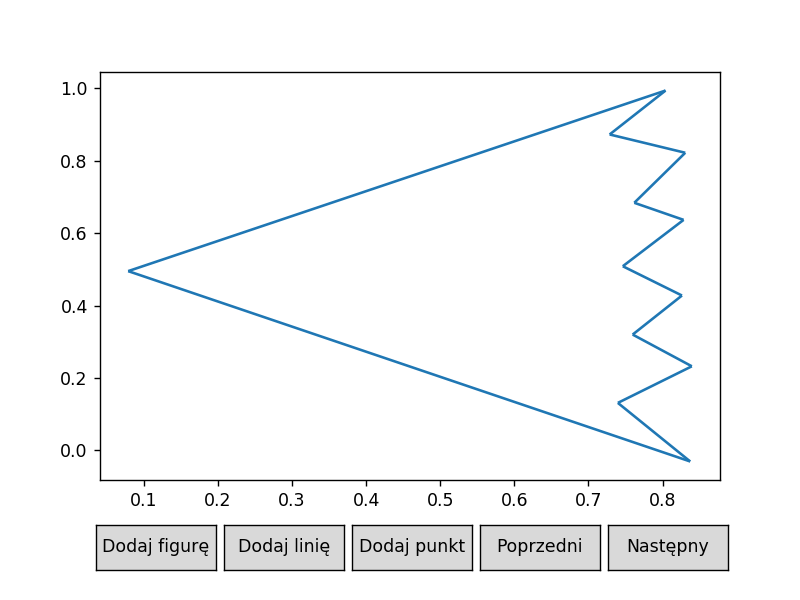

In [56]:
%matplotlib notebook
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()
